## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

--2021-03-24 09:06:43--  https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/jet.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263224 (257K) [image/bmp]
Saving to: ‘jet.bmp’

jet.bmp             100%[===================>] 257.05K  --.-KB/s    in 0.04s   

2021-03-24 09:06:44 (6.78 MB/s) - ‘jet.bmp’ saved [263224/263224]

178


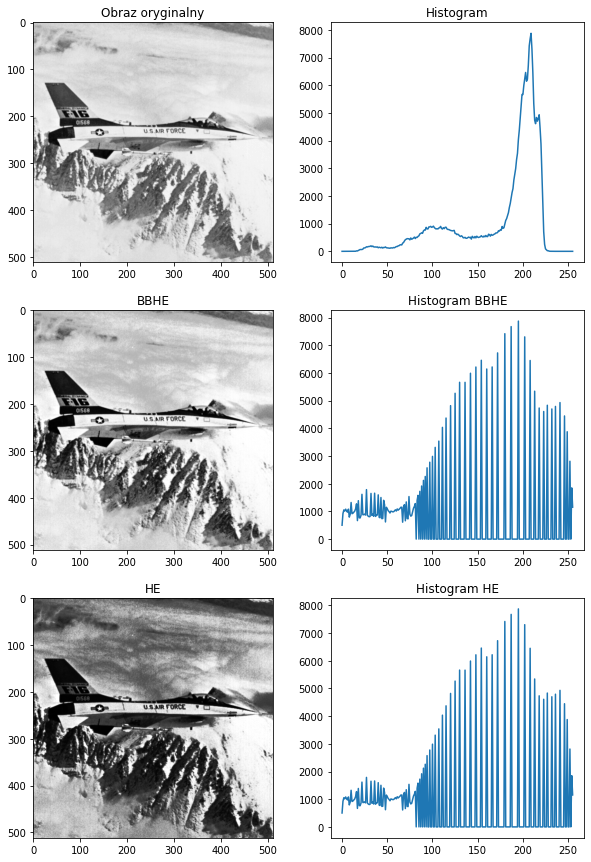

In [ ]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np

if not os.path.exists("jet.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/jet.bmp --no-check-certificate


#Załaowanie obrazu i wyliczenie histogramu
jet = cv2.imread("jet.bmp", cv2.IMREAD_GRAYSCALE)
jet_hist = cv2.calcHist([jet], [0], None, [256], [0, 256])

n = jet.shape[0] * jet.shape[1]
sum = 0
for i in range(0, jet.shape[0]):
    for j in range(0, jet.shape[1]):
        sum += jet[i][j]

#Obliczanie średniej jasności
lm = round(sum/n) 
print(lm)

#Podzielenie histogramu na dwa wg średniej janości i ich skumulowanie
H1 = jet_hist[0:lm]
H2 = jet_hist[lm:]
C1 = H1.cumsum()
C2 = H2.cumsum()

#Normalizacja histogramow
C1n = C1/(max(C1))
C2n = C2/(max(C2))

#Przeksztalcenie LUT
C1n = lm * C1n
C2n = lm + 1 + (255 - lm - 1) * C2n

#Konkantenacja tablic
C_LUT = np.concatenate((C1n, C2n))

BBHE = cv2.LUT(jet, C_LUT)
H_BBHE = cv2.calcHist([BBHE], [0], None, [256], [0, 256])
HE = cv2.equalizeHist(jet)
H_BBHE = cv2.calcHist([HE], [0], None, [256], [0, 256])



f2, ax2 = plt.subplots(3,2)
f2.set_size_inches(10, 15)
ax2[0, 0].imshow(jet, 'gray')
ax2[0, 0].set_title("Obraz oryginalny")
ax2[0, 1].plot(jet_hist)
ax2[0, 1].set_title('Histogram')
ax2[1, 0].imshow(BBHE, 'gray')
ax2[1, 0].set_title("BBHE")
ax2[1, 1].plot(H_BBHE)
ax2[1, 1].set_title('Histogram BBHE')
ax2[2, 0].imshow(HE, 'gray')
ax2[2, 0].set_title("HE")
ax2[2, 1].plot(H_BBHE)
ax2[2, 1].set_title('Histogram HE')
plt.show()


# Obraz stał się delikatnie ciemniejszy bo wyrównywanie przy uzyciu metody HE powoduje 
# że jasność obrazu zmierza do jego średniej jasności. Metoda HE dała obraz ciemniejszy niż metoda BBHE
# Z histogramów możemy odczytać, że srednia jasność wynosi około 180(jest to środek 
# miedzy warościami 100 a 250 dla których zauważamy znaczny wzrost wartosci histogramu). 